In [1]:
import numpy as np
from datetime import datetime
from pandas import read_table
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
import math

import time

import warnings
warnings.simplefilter('ignore')

In [2]:
import sys
sys.path.insert(0, 'funs')
import period_detect_funs

# functions

## 3 sigma and correction

In [3]:
def Z_fun(ts):
    mean = np.mean(ts)
    sigma = np.std(ts, ddof = 1)
    
    return mean, sigma

def Z_score_fun(ts):
    eps = 1e-8
    mean, sigma = Z_fun(ts)
    if sigma < 1e-8:
        sigma = 1
    len_ts = len(ts)
    Z_score = np.full(len_ts,np.nan)
    for i in range(len_ts):
        Z_score[i] = (ts[i] - mean)/sigma
    return Z_score

def outlier_detect_with_threshold(ts, threshold):
    outlier_detect_idx = np.array([],dtype = int)
    for i in range(len(ts)):
        if np.abs(ts[i])>threshold:
            outlier_detect_idx = np.append(outlier_detect_idx,i)
    return outlier_detect_idx

In [4]:
def outlier_median_correction(ts, outlier_idx_set):
    if len(outlier_idx_set) == 0:
        return ts
    ts_correction = ts.copy()
    median_ts = np.median(ts)
    for idx in outlier_idx_set:
        ts_correction[idx] = median_ts
    return ts_correction

In [5]:
def find_right_continues_idx(i, outlier_idx_set_sort):
    num_outlier = len(outlier_idx_set_sort)
    assert(num_outlier>i)
    idx_conti_set = np.array([], dtype = int)
    idx_conti_set = np.append(idx_conti_set, outlier_idx_set_sort[i])
    j = i + 1
    while j < num_outlier and outlier_idx_set_sort[j] - outlier_idx_set_sort[j-1] == 1:
        idx_conti_set = np.append(idx_conti_set, outlier_idx_set_sort[j])
        j = j + 1
    return idx_conti_set, j 

In [6]:
def outlier_linear_correction(ts, outlier_idx_set):
    if len(outlier_idx_set) == 0:
        return ts
    num_ts = len(ts)
    outlier_idx_set_sort = np.sort(outlier_idx_set)

    i = 0
    ts_correction = ts.copy()
    while i < len(outlier_idx_set):
        idx_conti_set, i = find_right_continues_idx(i, outlier_idx_set_sort)
        if idx_conti_set[0] == 0 and idx_conti_set[-1] == num_ts-1:
            return ts
        elif idx_conti_set[0] == 0 and idx_conti_set[-1] < num_ts-1:
            ts_correction[idx_conti_set] = ts[idx_conti_set[-1]+1]
        elif idx_conti_set[0] > 0 and idx_conti_set[-1] == num_ts-1:
            ts_correction[idx_conti_set] = ts[idx_conti_set[0]-1]
        else:
            idx_left = idx_conti_set[0]-1
            idx_right = idx_conti_set[-1]+1
            y_left = ts[idx_left]
            y_right = ts[idx_right]
            ts_correction[idx_conti_set] = y_left + (idx_conti_set - idx_left)*(y_right - y_left)/(idx_right - idx_left)
    return ts_correction     

## main

In [7]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [8]:
def main_period_fun(ts, threshold_low = 3, threshold_range = 3, current_value_flag = True, num_permutations = 100, confidence_interval = 0.99, random_seed = None, plot_flag = False):
    num = len(ts)
    # get acfs
    period_set, raw_acf_set_no = period_detect_funs.get_raw_acfs(ts)
    period_set, mean_acf_set, mean_acf_set_no = period_detect_funs.get_mean_acfs(ts, threshold_low, threshold_range)
    period_set, loess_acf_set, loess_acf_set_no = period_detect_funs.get_loess_acfs(ts, threshold_low, threshold_range, current_value_flag)
    
    # get period with max acf
    loess_max_id = np.argmax(loess_acf_set)
    loess_max_acf = loess_acf_set[loess_max_id]
    loess_period_detect = period_set[loess_max_id]
    
    loess_max_id_no = np.argmax(loess_acf_set_no)
    loess_max_acf_no = loess_acf_set_no[loess_max_id_no]
    loess_period_detect_no = period_set[loess_max_id_no]
    
    mean_max_id = np.argmax(mean_acf_set)
    mean_max_acf = mean_acf_set[mean_max_id]
    mean_period_detect = period_set[mean_max_id]
    
    mean_max_id_no = np.argmax(mean_acf_set_no)
    mean_max_acf_no = mean_acf_set_no[mean_max_id_no]
    mean_period_detect_no = period_set[mean_max_id_no]
    
    raw_max_id_no = np.argmax(raw_acf_set_no)
    raw_max_acf_no = raw_acf_set_no[raw_max_id_no]
    raw_period_detect_no = period_set[raw_max_id_no]
    
    data = [['period',str(loess_period_detect), str(loess_period_detect_no), str(mean_period_detect), str(mean_period_detect_no), str(raw_period_detect_no)],['acf',loess_max_acf, loess_max_acf_no, mean_max_acf, mean_max_acf_no, raw_max_acf_no]]
    df = pd.DataFrame(data,columns=['data','loess with weights', 'loess without weights', 'mean with weights', 'mean without weights', 'raw without detrend'])
    
    # auto period
    # get period hints
    fft_ks = period_detect_funs.getPeriodHints(ts, num_permutations, confidence_interval, random_seed)
    # raw acfs
    raw_periods_no = period_detect_funs.validation_all_hints(fft_ks, num, raw_acf_set_no)
    # mean acfs
    mean_periods_no = period_detect_funs.validation_all_hints(fft_ks, num, mean_acf_set_no)
    mean_periods = period_detect_funs.validation_all_hints(fft_ks, num, mean_acf_set)
    # loess acfs
    loess_periods_no = period_detect_funs.validation_all_hints(fft_ks, num, loess_acf_set_no)
    loess_periods = period_detect_funs.validation_all_hints(fft_ks, num, loess_acf_set)
    
    data_auto = [['period',str(loess_periods), str(loess_periods_no), str(mean_periods), str(mean_periods_no), str(raw_periods_no)]]
    df_auto = pd.DataFrame(data_auto,columns=['acf type','loess with weights', 'loess without weights', 'mean with weights', 'mean without weights', 'raw without detrend'])
    
    if plot_flag:
        plt.figure(figsize = (24, 4.5))
        plt.subplot(1,5,1)
        plt.plot(period_set, loess_acf_set)
        plt.grid()
        plt.xlabel('lag')
        plt.ylabel('acf')
        plt.title('loess acf with weights')
        plt.subplot(1,5,2)
        plt.plot(period_set, loess_acf_set_no)
        plt.grid()
        plt.xlabel('lag')
        plt.ylabel('acf')
        plt.title('loess acf without weights')
        plt.subplot(1,5,3)
        plt.plot(period_set, mean_acf_set)
        plt.grid()
        plt.xlabel('lag')
        plt.ylabel('acf')
        plt.title('mean acf with weights')
        plt.subplot(1,5,4)
        plt.plot(period_set, mean_acf_set_no)
        plt.grid()
        plt.xlabel('lag')
        plt.ylabel('acf')
        plt.title('mean acf without weights')
        plt.subplot(1,5,5)
        plt.plot(period_set, raw_acf_set_no)
        plt.grid()
        plt.xlabel('lag')
        plt.ylabel('acf')
        plt.title('raw acf without detrend')
    
    return df, df_auto

# test

## period = 40

### seasonal, no trend, T = 40

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 8466.43it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 7378.96it/s]

starting computations on 56 cores



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 915.10it/s]


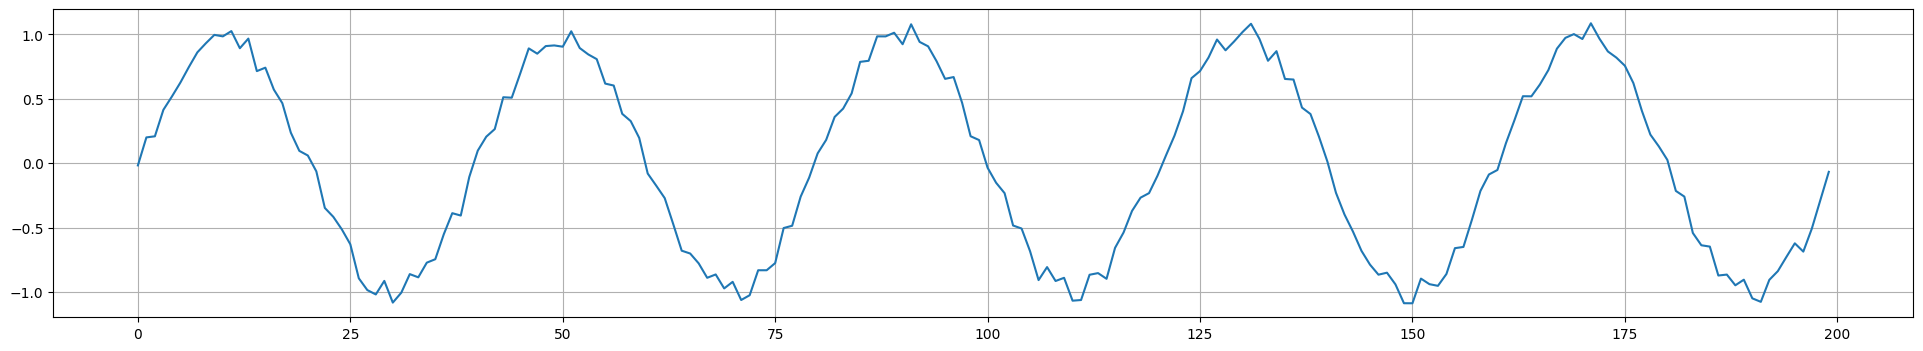

In [9]:
cols = 200 # length of time series
cycle = 40
random_seed = 1
np.random.seed(random_seed)
timestamp = np.full(cols,np.nan,dtype = int)
for i in range(cols):
    timestamp[i] = i
seasonal = np.full(cols,np.nan,dtype = float)
for i in range(cols):
    seasonal[i] = math.sin(2*math.pi/cycle*timestamp[i])
const = np.full(cols,2,dtype = float)
noise = np.full(cols,0,dtype = float)
for i in range(cols):
    noise[i] = 0.2*(np.random.rand()-0.5)
trend = 0.01*timestamp
ts = seasonal + noise
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [10]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,40,40,40,40,2
1,acf,0.79845,0.79845,0.80532,0.805316,0.943429


In [11]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[40],[40],[40],[40],[40]


### seasonal, no trend, outliers, T = 40

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 9007.88it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 8504.06it/s]

starting computations on 56 cores



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 923.80it/s]


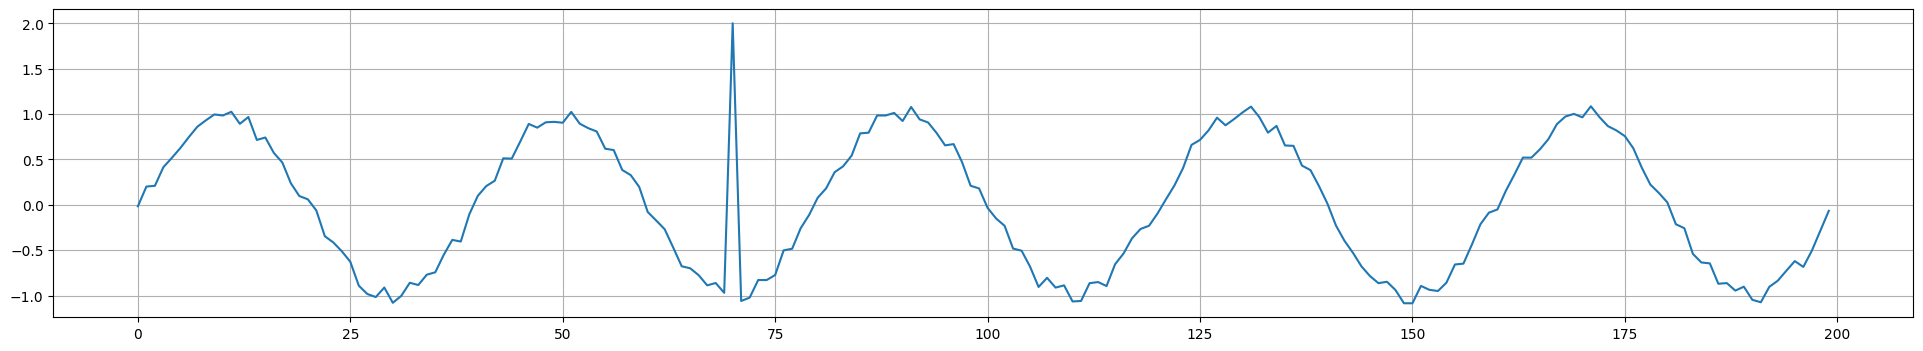

In [12]:
cols = 200 # length of time series
cycle = 40
random_seed = 1
np.random.seed(random_seed)
timestamp = np.full(cols,np.nan,dtype = int)
for i in range(cols):
    timestamp[i] = i
seasonal = np.full(cols,np.nan,dtype = float)
for i in range(cols):
    seasonal[i] = math.sin(2*math.pi/cycle*timestamp[i])
const = np.full(cols,2,dtype = float)
noise = np.full(cols,0,dtype = float)
for i in range(cols):
    noise[i] = 0.2*(np.random.rand()-0.5)
trend = 0.01*timestamp
ts = seasonal + noise
ts[70] = 2
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [13]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,40,40,40,39,2
1,acf,0.80044,0.717104,0.804519,0.716412,0.860824


In [14]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[40],[40],[40],[39],[40]


### seasonal, no outlier, T = 40

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 9946.49it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 7502.01it/s]

starting computations on 56 cores



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 881.40it/s]


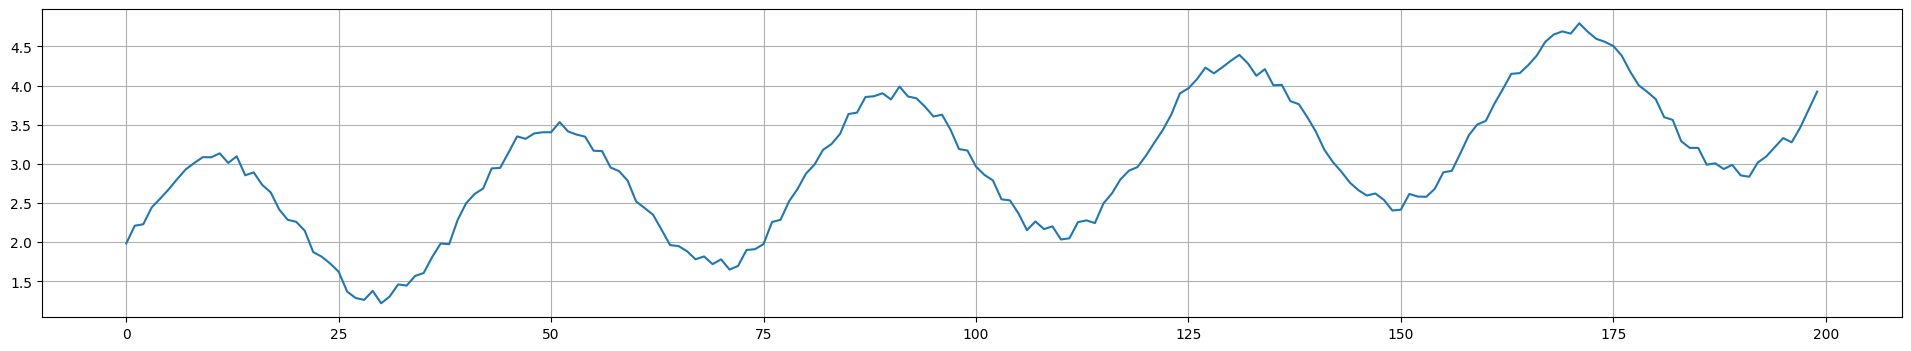

In [15]:
cols = 200 # length of time series
cycle = 40
random_seed = 1
np.random.seed(random_seed)
timestamp = np.full(cols,np.nan,dtype = int)
for i in range(cols):
    timestamp[i] = i
seasonal = np.full(cols,np.nan,dtype = float)
for i in range(cols):
    seasonal[i] = math.sin(2*math.pi/cycle*timestamp[i])
const = np.full(cols,2,dtype = float)
noise = np.full(cols,0,dtype = float)
for i in range(cols):
    noise[i] = 0.2*(np.random.rand()-0.5)
trend = 0.01*timestamp
ts = seasonal + const + noise + trend 
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [16]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,40,40,40,40,2
1,acf,0.79845,0.79845,0.804389,0.804356,0.949801


In [17]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[40],[40],[40],[40],[39]


### seasonal, outliers, T = 40

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 8055.64it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 6893.14it/s]

starting computations on 56 cores



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 807.99it/s]


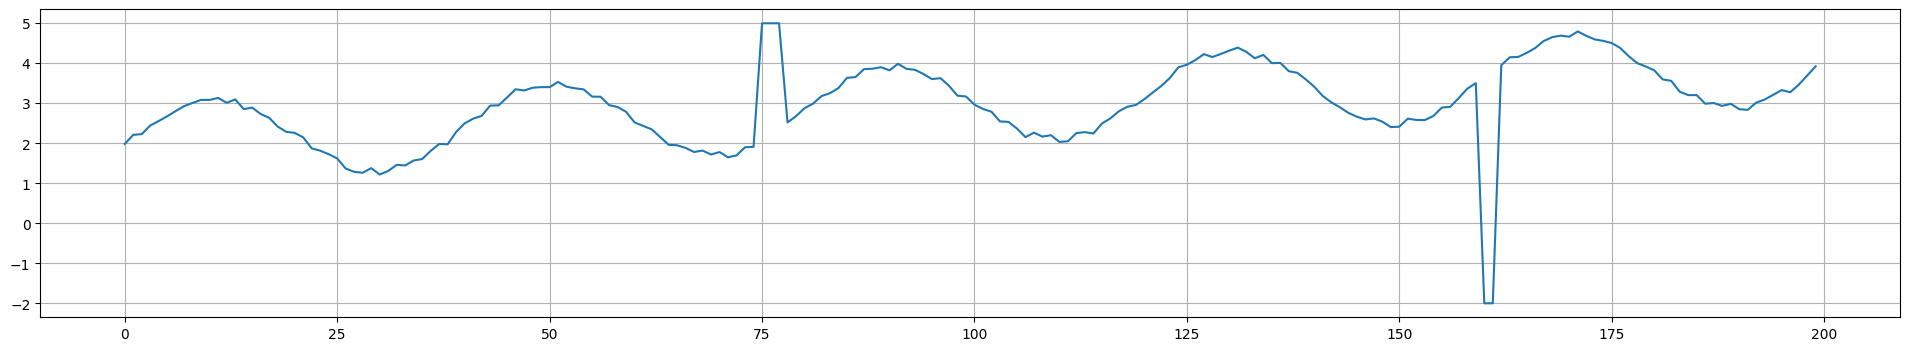

In [18]:
cols = 200 # length of time series
cycle = 40
random_seed = 1
np.random.seed(random_seed)
timestamp = np.full(cols,np.nan,dtype = int)
for i in range(cols):
    timestamp[i] = i
seasonal = np.full(cols,np.nan,dtype = float)
for i in range(cols):
    seasonal[i] = math.sin(2*math.pi/cycle*timestamp[i])
const = np.full(cols,2,dtype = float)
noise = np.full(cols,0,dtype = float)
for i in range(cols):
    noise[i] = 0.2*(np.random.rand()-0.5)
trend = 0.01*timestamp
ts = seasonal + const + noise + trend 
ts[75] = 5
ts[76] = 5
ts[77] = 5
ts[160] = -2
ts[161] = -2
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [19]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,40,41,40,41,2
1,acf,0.634696,0.420896,0.586577,0.397097,0.559679


In [20]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[40],[41],[40],[41],[41]


## period = 365

### tsdl_271.csv

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8590.27it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 5127.43it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 89.89it/s]


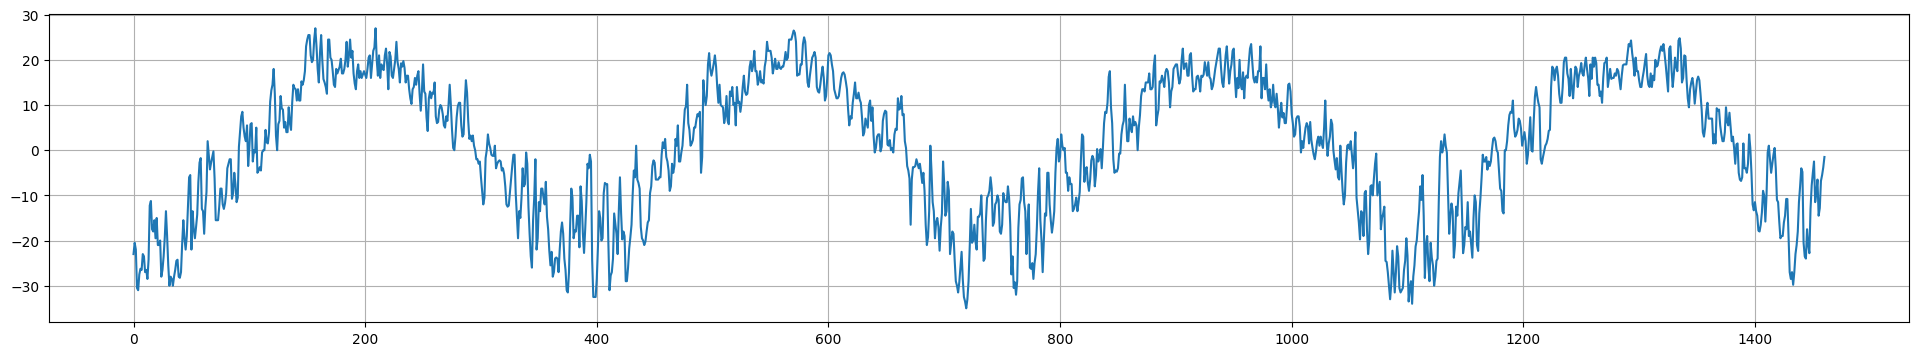

In [21]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_271.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [22]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,364,364,364,364,2
1,acf,0.649755,0.648864,0.630273,0.62932,0.917453


In [23]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[364],[364],[364],[364],[349]


### tsdl_271.csv, two outliers

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8702.42it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 5214.74it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 90.90it/s]


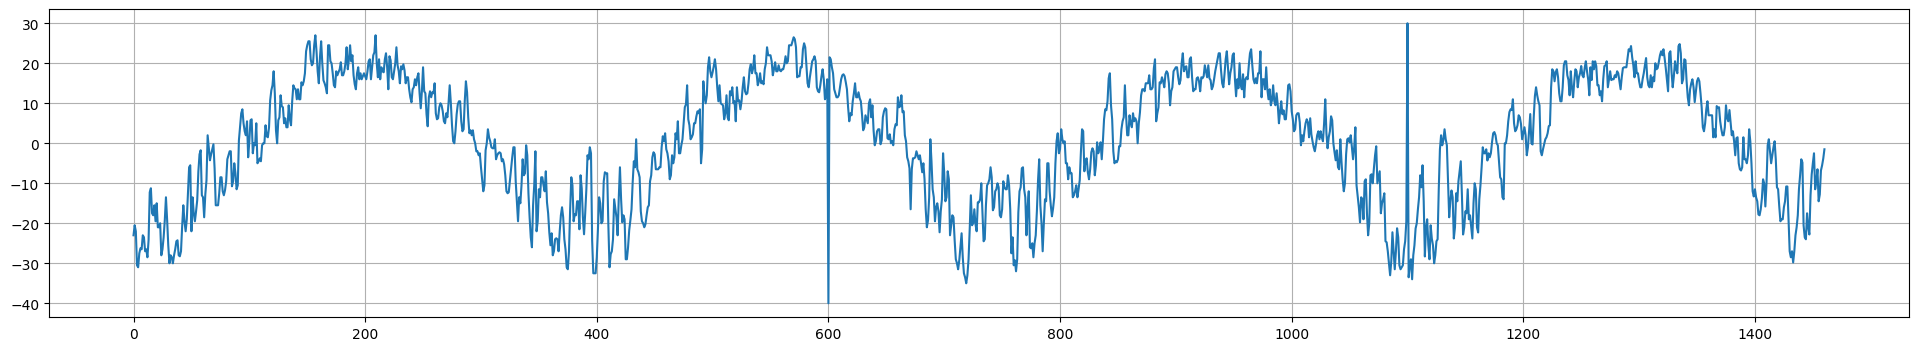

In [24]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_271.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[600] = -40
ts[1100] = 30
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [25]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,364,362,364,362,2
1,acf,0.648789,0.639398,0.629613,0.618152,0.898648


In [26]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[364],[362],[364],[362],[349]


### tsdl_331.csv

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8598.73it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 5331.82it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 90.34it/s]


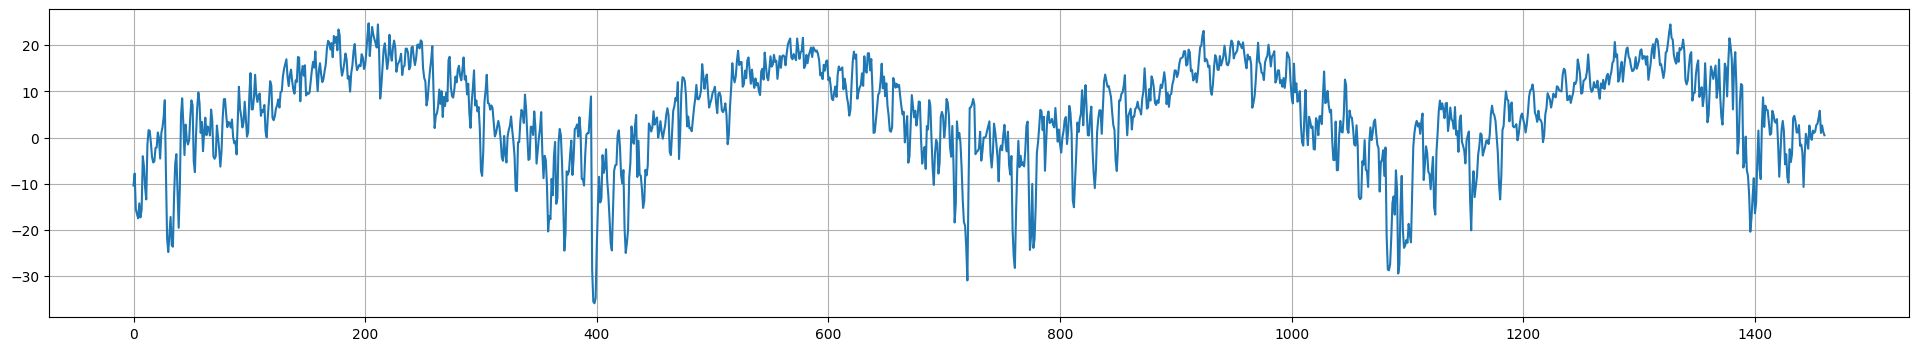

In [27]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [28]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,365,365,365,365,2
1,acf,0.521299,0.517109,0.489163,0.485869,0.805155


In [29]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[365],[365],[365],[365],[365]


### tsdl_331.csv, 3 sigma and linear interpolation

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8333.17it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4517.96it/s]


starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 90.04it/s]


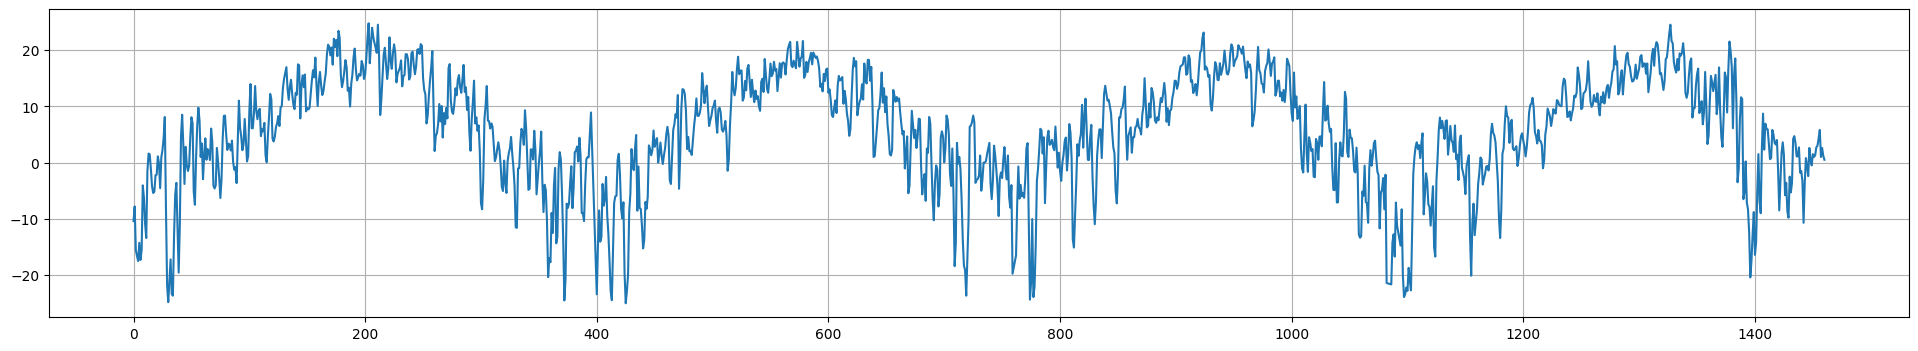

In [30]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
Z_score = Z_score_fun(ts)
threshold_sigma = 3
outlier_detect_idx = outlier_detect_with_threshold(Z_score, threshold_sigma)
ts_linear_correction = outlier_linear_correction(ts, outlier_detect_idx)
plt.figure(figsize = (24, 4))
plt.plot(ts_linear_correction)
plt.grid()
df, df_auto = main_period_fun(ts_linear_correction, random_seed = 123)

In [31]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,350,349,368,367,2
1,acf,0.525777,0.522474,0.490175,0.481905,0.814214


In [32]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[350],[349],[368],[367],[349]


### tsdl_331.csv, 3 sigma and median interpolation

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8107.20it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4049.42it/s]


starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 87.20it/s]


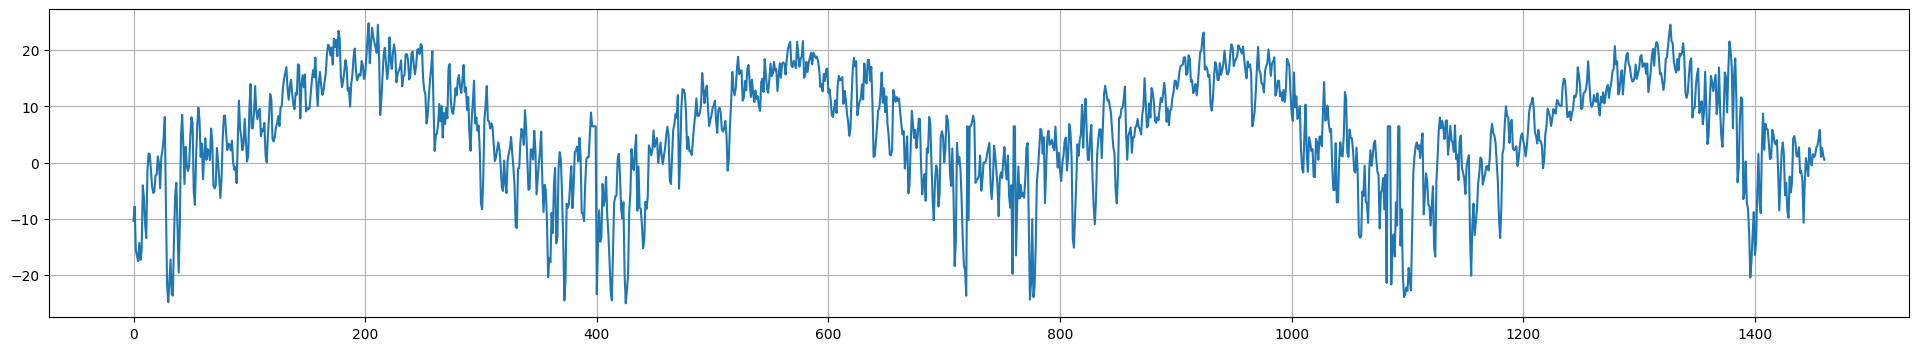

In [33]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
Z_score = Z_score_fun(ts)
threshold_sigma = 3
outlier_detect_idx = outlier_detect_with_threshold(Z_score, threshold_sigma)
ts_median_correction = outlier_median_correction(ts, outlier_detect_idx)
plt.figure(figsize = (24, 4))
plt.plot(ts_median_correction)
plt.grid()
df, df_auto = main_period_fun(ts_median_correction, random_seed = 123)

In [34]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,350,350,370,350,2
1,acf,0.518357,0.512726,0.480878,0.471734,0.79059


In [35]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[350],[350],[370],[350],[350]


### tsdl_331.csv, two outliers

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8148.23it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4414.25it/s]


starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 89.34it/s]


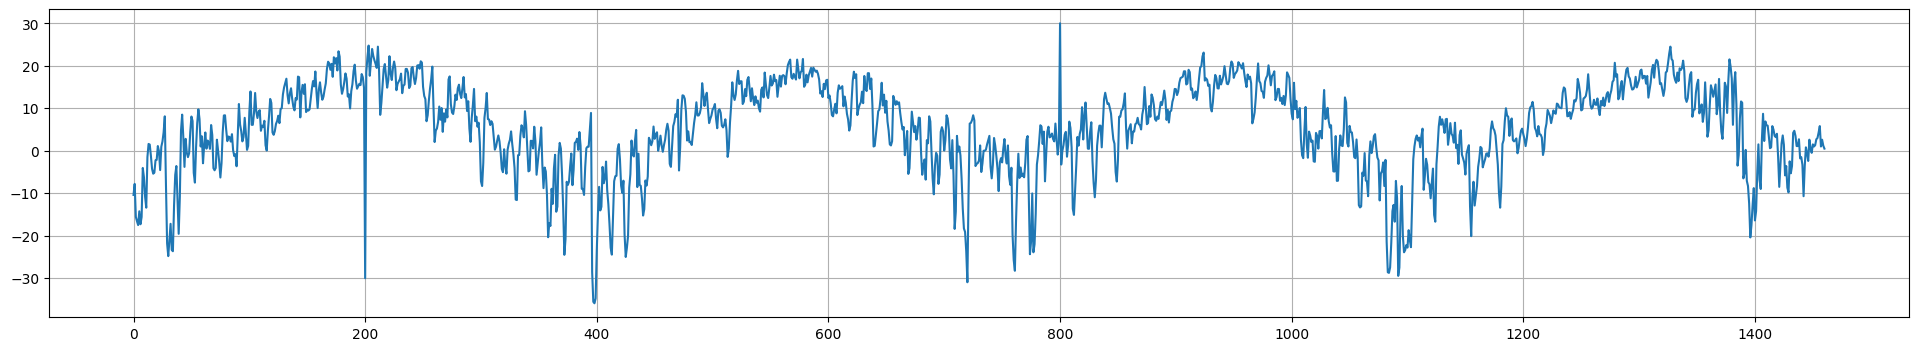

In [36]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[200] = -30
ts[800] = 30
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [37]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,365,364,365,364,2
1,acf,0.516366,0.503553,0.483198,0.470362,0.786043


In [38]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[365],[364],[365],[364],[364]


### tsdl_331.csv, two outliers, 3 sigma and linear interpolation

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8169.43it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4942.48it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 91.08it/s]


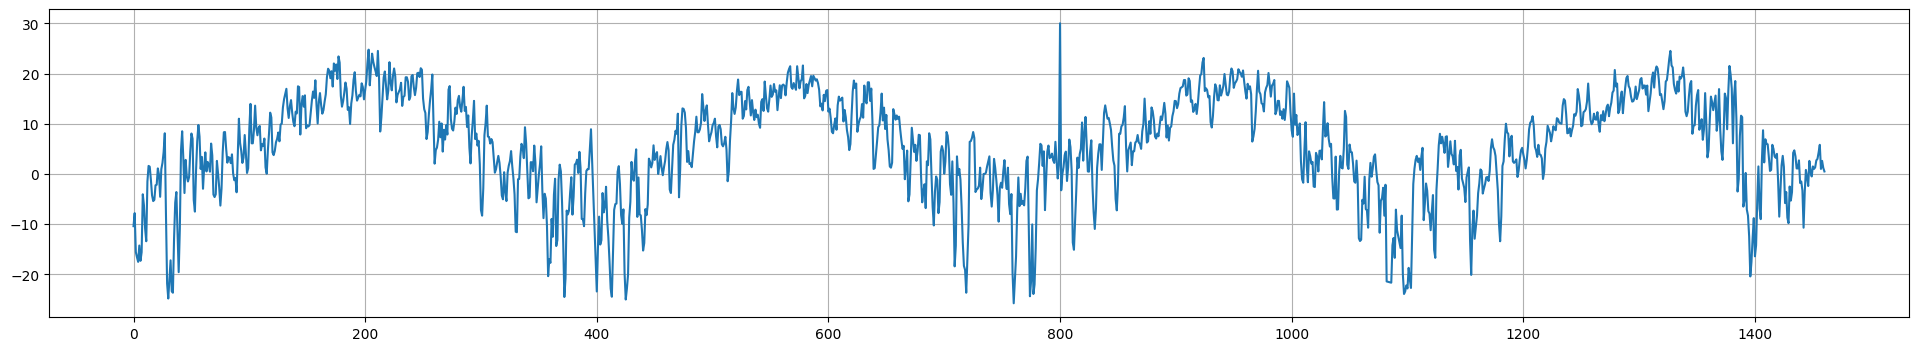

In [39]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[200] = -30
ts[800] = 30
Z_score = Z_score_fun(ts)
threshold_sigma = 3
outlier_detect_idx = outlier_detect_with_threshold(Z_score, threshold_sigma)
ts_linear_correction = outlier_linear_correction(ts, outlier_detect_idx)
plt.figure(figsize = (24, 4))
plt.plot(ts_linear_correction)
plt.grid()
df, df_auto = main_period_fun(ts_linear_correction, random_seed = 123)

In [40]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,350,349,368,349,2
1,acf,0.522306,0.518597,0.484771,0.477611,0.808033


In [41]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[350],[349],[368],[349],[349]


### tsdl_331.csv, two outliers, 3 sigma and median interpolation

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 8365.04it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4577.65it/s]


starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 89.30it/s]


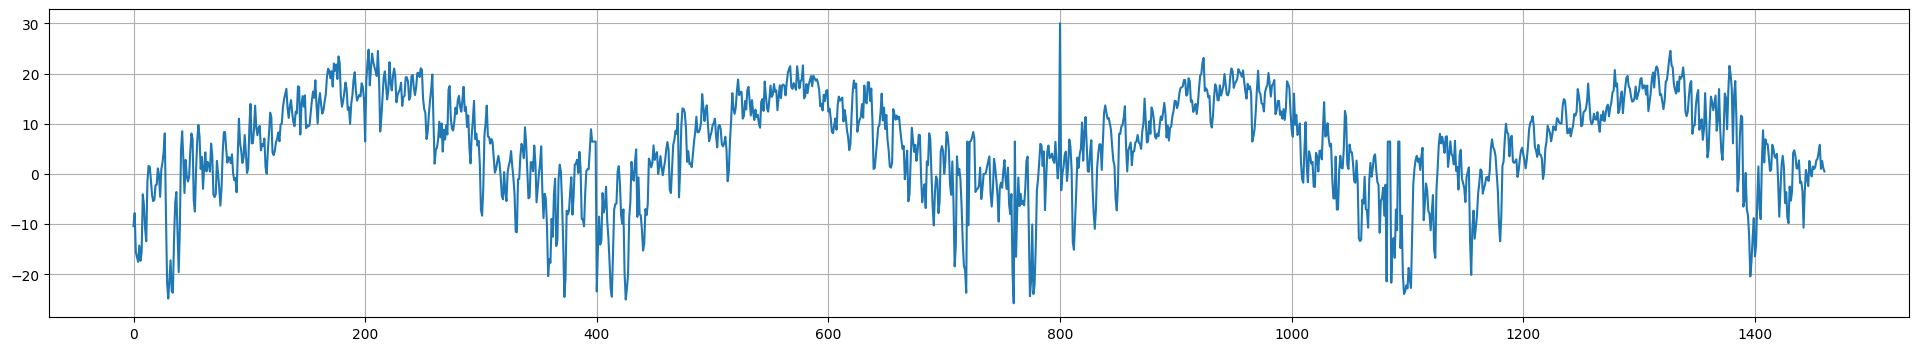

In [42]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[200] = -30
ts[800] = 30
Z_score = Z_score_fun(ts)
threshold_sigma = 3
outlier_detect_idx = outlier_detect_with_threshold(Z_score, threshold_sigma)
ts_median_correction = outlier_median_correction(ts, outlier_detect_idx)
plt.figure(figsize = (24, 4))
plt.plot(ts_median_correction)
plt.grid()
df, df_auto = main_period_fun(ts_median_correction, random_seed = 123)

In [43]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,350,349,350,349,2
1,acf,0.515705,0.509688,0.476097,0.468733,0.785383


In [44]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[350],[349],[350],[349],[349]


### tsdl_331.csv, two outliers, case 2

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 7857.47it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4870.17it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 89.84it/s]


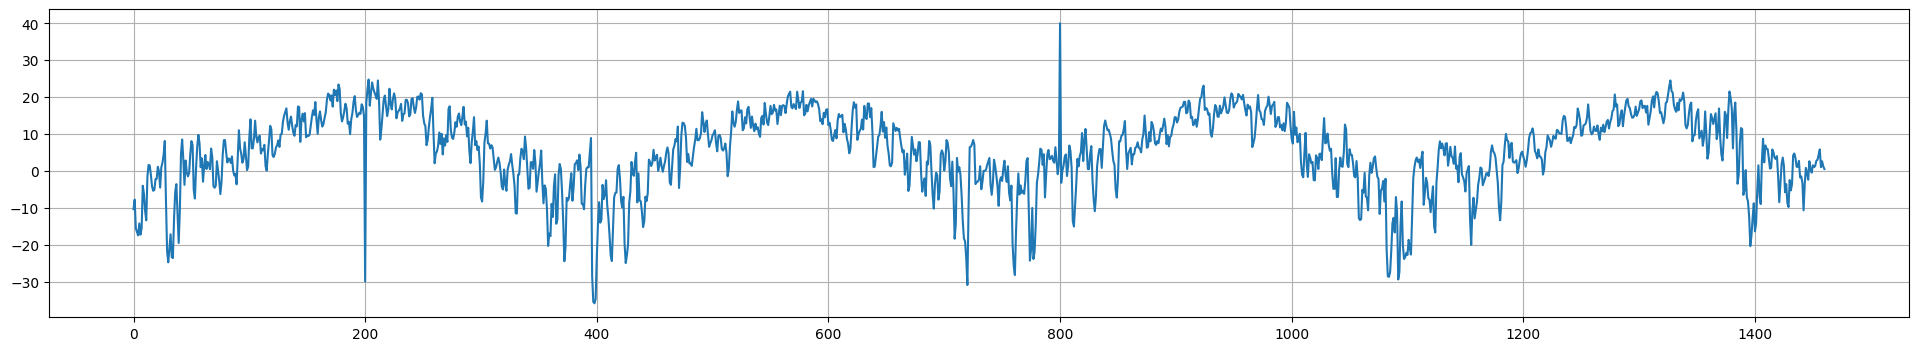

In [45]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[200] = -30
ts[800] = 40
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [46]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,365,364,365,364,2
1,acf,0.518769,0.501098,0.486302,0.467918,0.782398


In [47]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[365],[364],[365],[364],[364]


### tsdl_331.csv, two outliers, case 2, 3 sigma and linear interpolation

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 7840.36it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4995.91it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 90.50it/s]


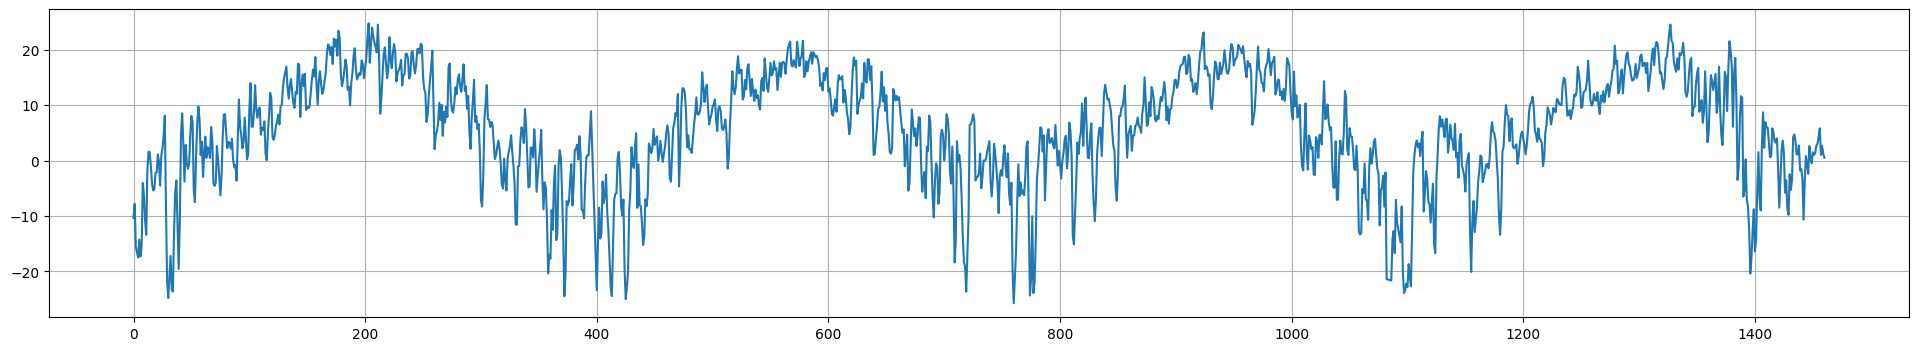

In [48]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[200] = -30
ts[800] = 40
Z_score = Z_score_fun(ts)
threshold_sigma = 3
outlier_detect_idx = outlier_detect_with_threshold(Z_score, threshold_sigma)
ts_linear_correction = outlier_linear_correction(ts, outlier_detect_idx)
plt.figure(figsize = (24, 4))
plt.plot(ts_linear_correction)
plt.grid()
df, df_auto = main_period_fun(ts_linear_correction, random_seed = 123)

In [49]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,350,349,368,349,2
1,acf,0.525398,0.522408,0.489076,0.481437,0.81358


In [50]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[350],[349],[368],[349],[349]


### tsdl_331.csv, two outliers, case 2, 3 sigma and median interpolation

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 7654.43it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 4338.04it/s]


starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:08<00:00, 88.91it/s]


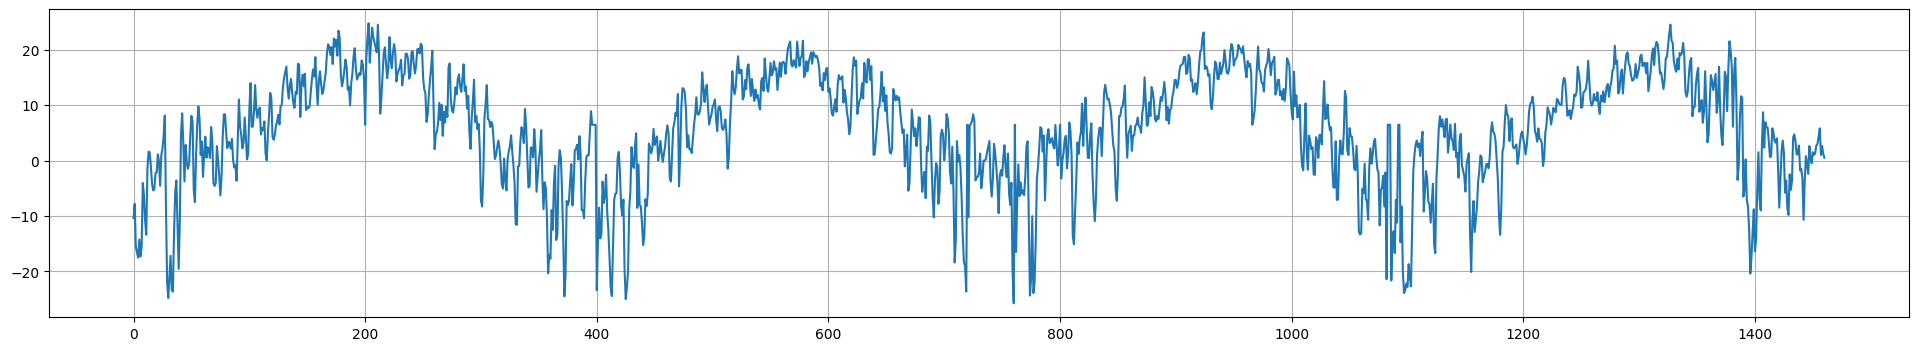

In [51]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_331.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[200] = -30
ts[800] = 40
Z_score = Z_score_fun(ts)
threshold_sigma = 3
outlier_detect_idx = outlier_detect_with_threshold(Z_score, threshold_sigma)
ts_median_correction = outlier_median_correction(ts, outlier_detect_idx)
plt.figure(figsize = (24, 4))
plt.plot(ts_median_correction)
plt.grid()
df, df_auto = main_period_fun(ts_median_correction, random_seed = 123)

In [52]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,350,349,350,349,2
1,acf,0.518214,0.513325,0.479325,0.472457,0.790659


In [53]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[350],[349],[350],[349],[349]


## period = 52

### tsdl_91.csv, weekly

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 8031.68it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 6233.97it/s]

starting computations on 56 cores



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 365.16it/s]


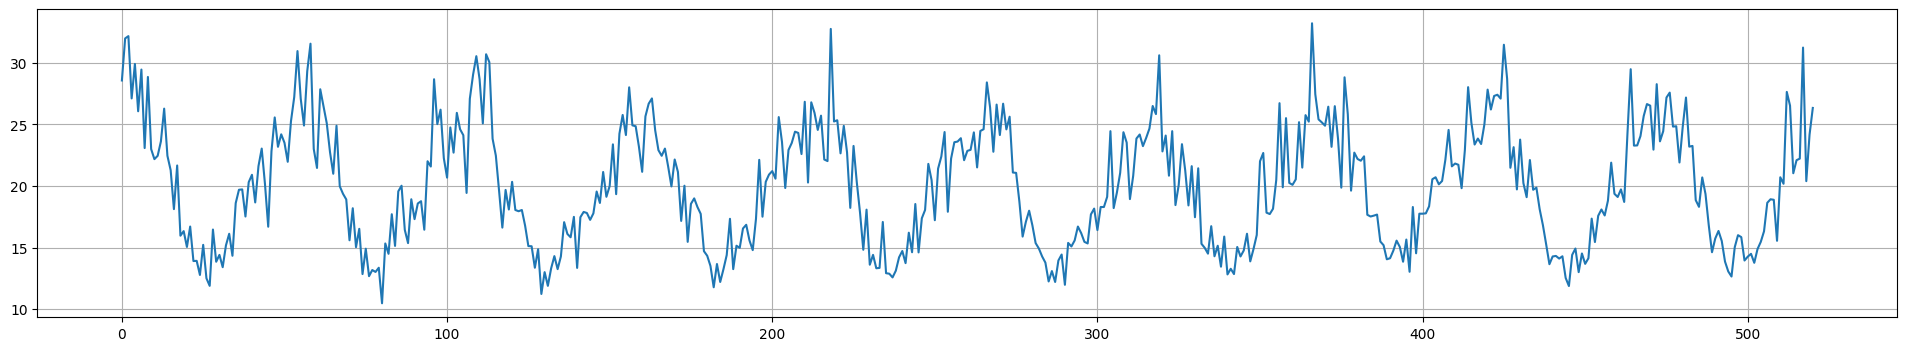

In [54]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_91.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
num_w = int(num/7)
ts_w = np.full(num_w,np.nan)
for i in range(num_w):
    ts_w[i] = np.mean(ts[7*i:7*i+7])
plt.figure(figsize = (24, 4))
plt.plot(ts_w)
plt.grid()
df, df_auto = main_period_fun(ts_w, random_seed = 123)

In [55]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,52,52,52,53,2
1,acf,0.733768,0.730203,0.717343,0.716579,0.77223


In [56]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[52],[52],[52],[53],[52]


### tsdl_91.csv, weekly, three outliers

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 8701.95it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 6362.82it/s]

starting computations on 56 cores



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 374.00it/s]


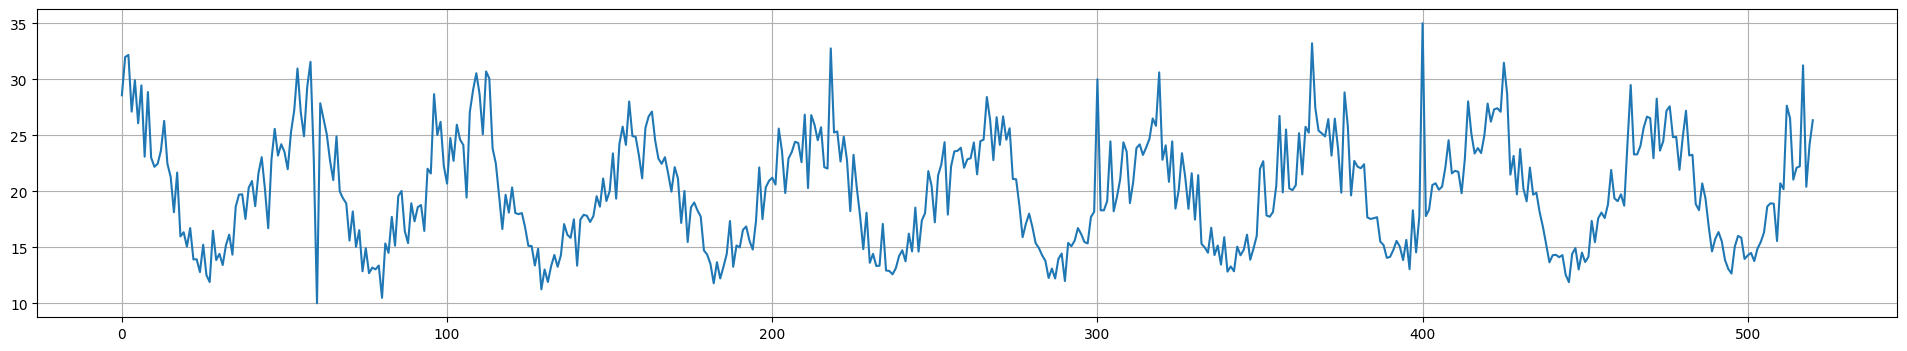

In [57]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_91.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
num_w = int(num/7)
ts_w = np.full(num_w,np.nan)
for i in range(num_w):
    ts_w[i] = np.mean(ts[7*i:7*i+7])
ts_w[60] = 10
ts_w[400] = 35
ts_w[300] = 30
plt.figure(figsize = (24, 4))
plt.plot(ts_w)
plt.grid()
df, df_auto = main_period_fun(ts_w, random_seed = 123)

In [58]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,52,51,52,53,2
1,acf,0.727731,0.683026,0.707727,0.663771,0.71667


In [59]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[52],[51],[52],[53],[50]


### tsdl_92.csv, weekly

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 8599.58it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 6094.18it/s]

starting computations on 56 cores



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 359.72it/s]


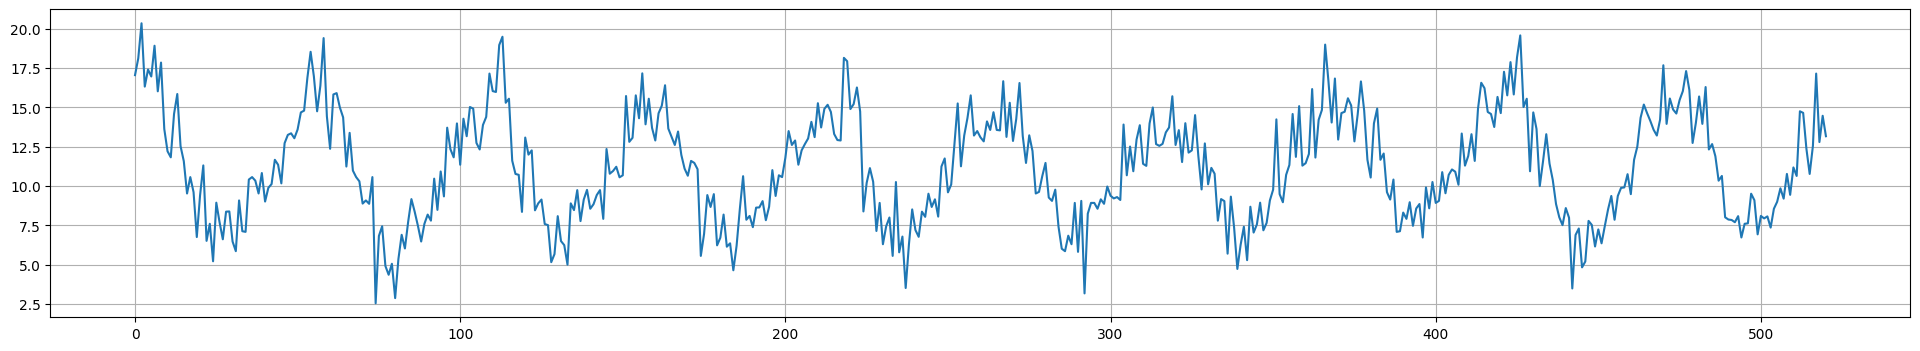

In [60]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_92.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
num_w = int(num/7)
ts_w = np.full(num_w,np.nan)
for i in range(num_w):
    ts_w[i] = np.mean(ts[7*i:7*i+7])
plt.figure(figsize = (24, 4))
plt.plot(ts_w)
plt.grid()
df, df_auto = main_period_fun(ts_w, random_seed = 123)

In [61]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,52,52,52,52,2
1,acf,0.727401,0.727047,0.709176,0.708942,0.771543


In [62]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[52],[52],[52],[52],[52]


### tsdl_92.csv, weekly, an outlier

starting computations on 56 cores


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 8583.48it/s]

starting computations on 56 cores



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 6299.80it/s]

starting computations on 56 cores



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 376.59it/s]


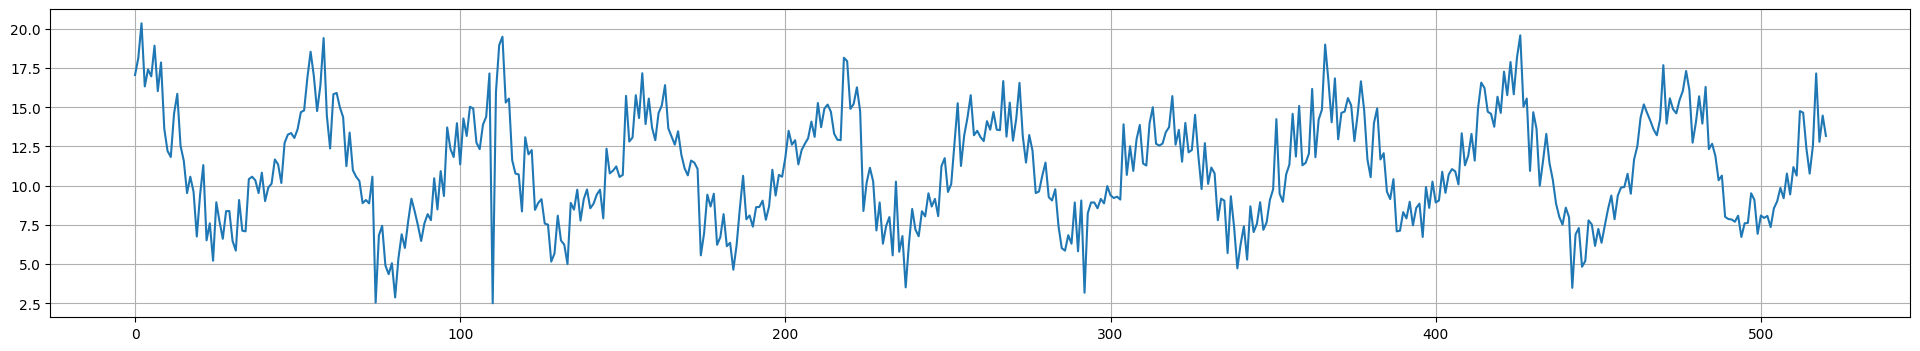

In [78]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_92.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
num_w = int(num/7)
ts_w = np.full(num_w,np.nan)
for i in range(num_w):
    ts_w[i] = np.mean(ts[7*i:7*i+7])
ts_w[110] = 2.5
plt.figure(figsize = (24, 4))
plt.plot(ts_w)
plt.grid()
df, df_auto = main_period_fun(ts_w, random_seed = 123)

In [79]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,52,50,52,50,2
1,acf,0.723852,0.697981,0.705691,0.674378,0.740424


In [80]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[52],[50],[52],[50],[50]


## period = 12

### tsdl_244.csv

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 6181.05it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 5387.75it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 1261.82it/s]


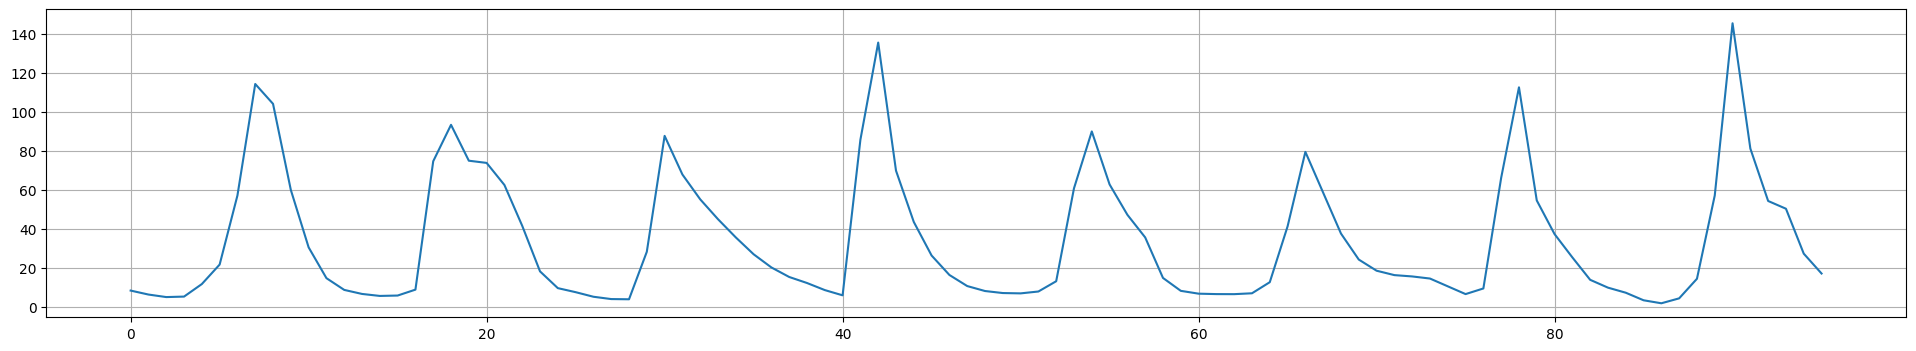

In [66]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_244.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [67]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,12,12,12,12,12
1,acf,0.73109,0.729456,0.723101,0.722787,0.696978


In [68]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[12],[12],[12],[12],[12]


### tsdl_244.csv, one outlier

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 5787.79it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 5678.10it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 1188.86it/s]


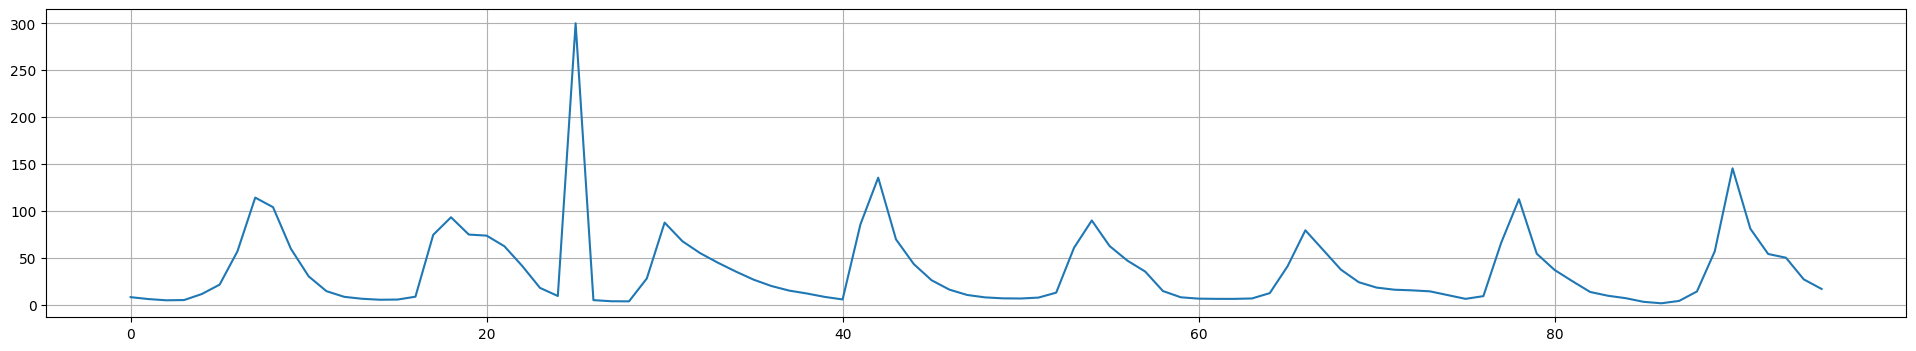

In [69]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_244.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[25] = 300
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [70]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,12,12,12,12,12
1,acf,0.722559,0.348331,0.643658,0.314418,0.336188


In [71]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[12],[12],[12],[12],[12]


### tsdl_358.csv

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 5896.47it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 5407.86it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1164.04it/s]


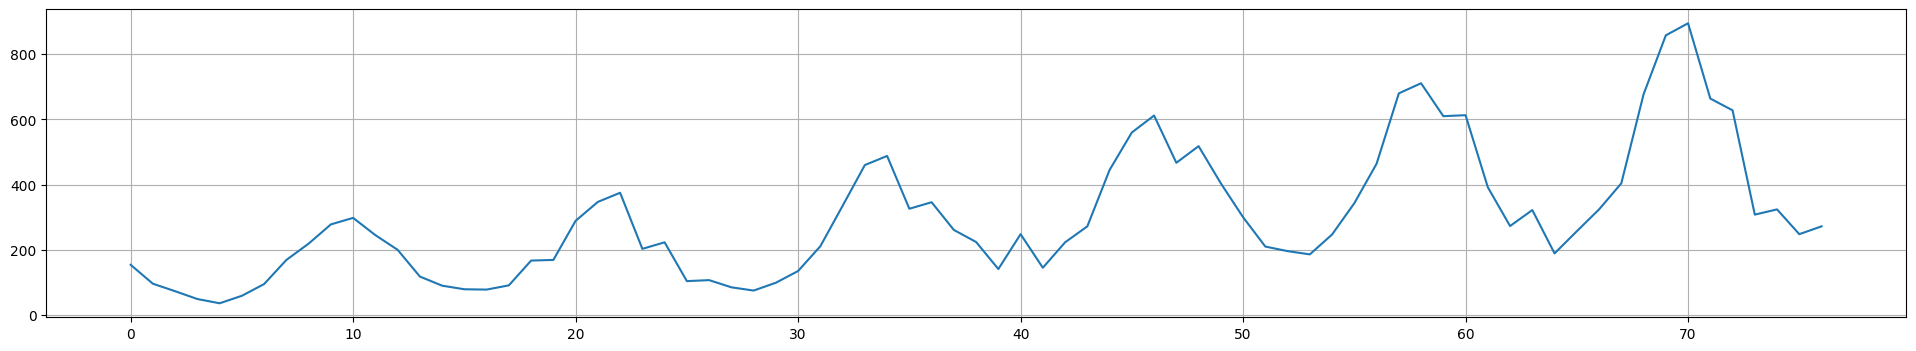

In [72]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_358.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [73]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,12,12,12,12,12
1,acf,0.744587,0.744307,0.739812,0.739324,0.669822


In [74]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[12],[12],[12],[12],[12]


### tsdl_358.csv, two outliers

starting computations on 56 cores


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 5663.84it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 5157.33it/s]

starting computations on 56 cores



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1289.45it/s]


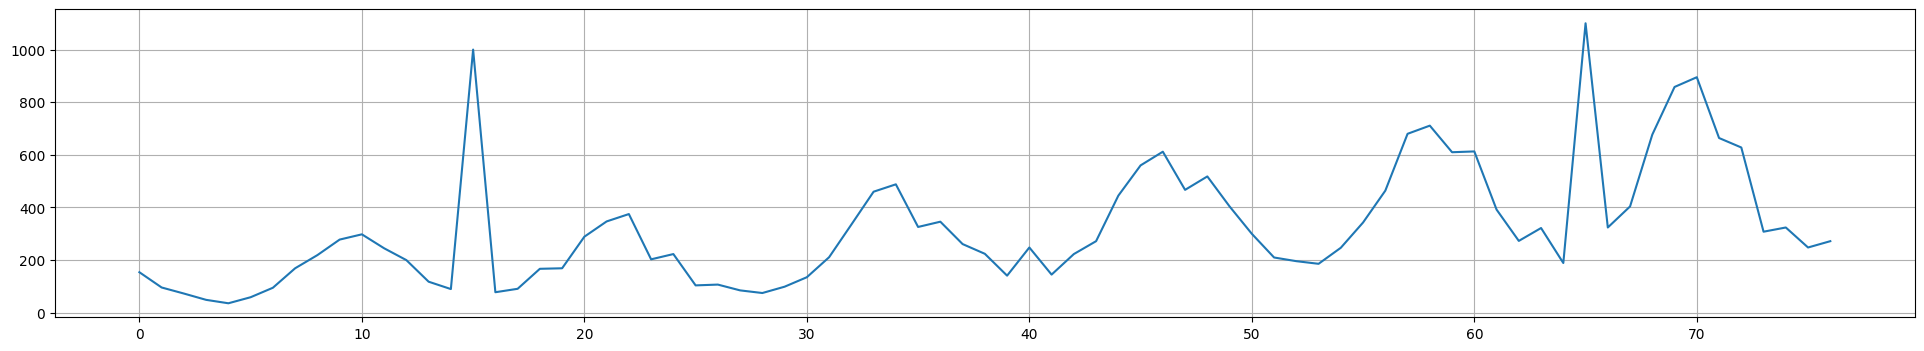

In [75]:
str_path = 'data/tsdl_data/'
df = pd.read_csv(str_path+'tsdl_358.csv')
num = len(df)
ts = np.full(num,np.nan)
for i in range(num):
    ts[i] = df['value'][i]
ts[15] = 1000
ts[65] = 1100
plt.figure(figsize = (24, 4))
plt.plot(ts)
plt.grid()
df, df_auto = main_period_fun(ts, random_seed = 123)

In [76]:
df

,data,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,12,12,12,12,2
1,acf,0.48107,0.370527,0.466437,0.373427,0.414631


In [77]:
df_auto

,acf type,loess with weights,loess without weights,mean with weights,mean without weights,raw without detrend
0,period,[],[],[],[],[]
